In [1022]:
# Importieren wichtiger Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [1023]:
data  = pd.read_csv("data.csv")
data.head()

,Zeitstempel,Filiale,Artikel,Menge,Umsatz,Bestellungen,Temperatur,Niederschlag,Globalstrahlung,Temperatur Schnitt Tag,Niederschlag Summe Tag,Globalstrahlung Schnitt Tag
0,2016-01-03 08:01:46,Sulgen Filiale,Butterzopf mittel,1.0,6.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN
1,2016-01-03 08:04:45,Sulgen Filiale,Buttergipfeli,2.0,2.6,0.0,NaN,0.0,NaN,NaN,0.0,NaN
2,2016-01-03 08:09:21,Sulgen Filiale,Buttergipfeli,12.0,15.6,0.0,NaN,0.0,NaN,NaN,0.0,NaN
3,2016-01-03 08:11:19,Sulgen Filiale,Butterzopf mittel,1.0,6.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN
4,2016-01-03 08:11:19,Sulgen Filiale,Buttergipfeli,4.0,5.2,0.0,NaN,0.0,NaN,NaN,0.0,NaN


In [1024]:
data_backup = data.copy()

# Transformation des Datensatzes
data["Zeitstempel"] = pd.to_datetime(data["Zeitstempel"])
data["Uhrzeit"] = pd.to_datetime(data["Zeitstempel"]).dt.time
data["Stunde"] = pd.to_datetime(data["Zeitstempel"]).dt.hour
data["Datum"] = pd.to_datetime(data["Zeitstempel"]).dt.date
data["Wochentag"] = pd.to_datetime(data["Zeitstempel"]).dt.day_name()

data.head()

,Zeitstempel,Filiale,Artikel,Menge,Umsatz,Bestellungen,Temperatur,Niederschlag,Globalstrahlung,Temperatur Schnitt Tag,Niederschlag Summe Tag,Globalstrahlung Schnitt Tag,Uhrzeit,Stunde,Datum,Wochentag
0,2016-01-03 08:01:46,Sulgen Filiale,Butterzopf mittel,1.0,6.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,08:01:46,8,2016-01-03,Sunday
1,2016-01-03 08:04:45,Sulgen Filiale,Buttergipfeli,2.0,2.6,0.0,NaN,0.0,NaN,NaN,0.0,NaN,08:04:45,8,2016-01-03,Sunday
2,2016-01-03 08:09:21,Sulgen Filiale,Buttergipfeli,12.0,15.6,0.0,NaN,0.0,NaN,NaN,0.0,NaN,08:09:21,8,2016-01-03,Sunday
3,2016-01-03 08:11:19,Sulgen Filiale,Butterzopf mittel,1.0,6.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,08:11:19,8,2016-01-03,Sunday
4,2016-01-03 08:11:19,Sulgen Filiale,Buttergipfeli,4.0,5.2,0.0,NaN,0.0,NaN,NaN,0.0,NaN,08:11:19,8,2016-01-03,Sunday


In [1025]:
# Konvertieren der Spalten in die richtige Datentypen
data["Datum"] = pd.to_datetime(data["Datum"]).dt.date
wochentag_reihenfolge = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
data["Wochentag"] = pd.Categorical(data["Wochentag"], categories = wochentag_reihenfolge, ordered = True)
data['Monat'] = pd.to_datetime(data['Datum']).dt.month

# Entfernen nicht mehr benötigter Spalten
data = data.drop(columns = ["Filiale", "Zeitstempel"], axis = "columns")

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 727754 entries, 0 to 727753
Data columns (total 15 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   Artikel                      727754 non-null  object  
 1   Menge                        727754 non-null  float64 
 2   Umsatz                       727754 non-null  float64 
 3   Bestellungen                 727754 non-null  float64 
 4   Temperatur                   718722 non-null  float64 
 5   Niederschlag                 725226 non-null  float64 
 6   Globalstrahlung              718722 non-null  float64 
 7   Temperatur Schnitt Tag       719687 non-null  float64 
 8   Niederschlag Summe Tag       727754 non-null  float64 
 9   Globalstrahlung Schnitt Tag  719687 non-null  float64 
 10  Uhrzeit                      727754 non-null  object  
 11  Stunde                       727754 non-null  int64   
 12  Datum                        727754 non-null

In [1026]:
# Im nächsten Schritt prüfen wir Transaktionen außerhalb der Öffnungszeiten. Im Maximum hat die Bäckerrei von 5:30 bis 19:00 geöffnet.
# Zu erst werden Transaktionen vor Öffnung geprüft.
data_4_uhr = data[data["Stunde"] == 4]
data_4_uhr.head()

# Da sich in einem Histogramm über den Umsatz pro Uhrzeit pro Tag Ausreißer um 4 Uhr finden, werden alle Einträge vor 5 Uhr entfernt.
data = data[data["Stunde"] >= 5]

# 
data_20_uhr = data[data["Stunde"] == 20]
data_20_uhr.head()

#Duplikate entfernen

data.drop_duplicates(inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 719185 entries, 0 to 727753
Data columns (total 15 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   Artikel                      719185 non-null  object  
 1   Menge                        719185 non-null  float64 
 2   Umsatz                       719185 non-null  float64 
 3   Bestellungen                 719185 non-null  float64 
 4   Temperatur                   710279 non-null  float64 
 5   Niederschlag                 716688 non-null  float64 
 6   Globalstrahlung              710279 non-null  float64 
 7   Temperatur Schnitt Tag       711227 non-null  float64 
 8   Niederschlag Summe Tag       719185 non-null  float64 
 9   Globalstrahlung Schnitt Tag  711227 non-null  float64 
 10  Uhrzeit                      719185 non-null  object  
 11  Stunde                       719185 non-null  int64   
 12  Datum                        719185 non-null

In [1027]:
# neue Kolumnen für Temperatur und Globalstrahlung einfügen
data = data.drop(columns = ["Temperatur", "Globalstrahlung"], axis = "columns")
data.head()

,Artikel,Menge,Umsatz,Bestellungen,Niederschlag,Temperatur Schnitt Tag,Niederschlag Summe Tag,Globalstrahlung Schnitt Tag,Uhrzeit,Stunde,Datum,Wochentag,Monat
0,Butterzopf mittel,1.0,6.0,0.0,0.0,NaN,0.0,NaN,08:01:46,8,2016-01-03,Sunday,1
1,Buttergipfeli,2.0,2.6,0.0,0.0,NaN,0.0,NaN,08:04:45,8,2016-01-03,Sunday,1
2,Buttergipfeli,12.0,15.6,0.0,0.0,NaN,0.0,NaN,08:09:21,8,2016-01-03,Sunday,1
3,Butterzopf mittel,1.0,6.0,0.0,0.0,NaN,0.0,NaN,08:11:19,8,2016-01-03,Sunday,1
4,Buttergipfeli,4.0,5.2,0.0,0.0,NaN,0.0,NaN,08:11:19,8,2016-01-03,Sunday,1


In [1028]:
# Stückpreis berechnet
data["Stückpreis"] = pd.to_numeric(data["Umsatz"] / data["Menge"]).apply(lambda x: '{:.2f}'.format(x))

# Sortieren nach Stückpreis
data_preis = data.sort_values(by='Stückpreis', ascending=True)

In [1029]:
n_produkte = data["Artikel"].unique()

# Erstellen einer Produktliste mit der verkauften Anzahl
produkt_liste = data[["Artikel", "Menge"]].groupby("Artikel").sum().sort_values(by="Menge", ascending=False).reset_index()


print("Es sind folgende Produkte im Datensatz enthalten: ")
print(produkt_liste)

Es sind folgende Produkte im Datensatz enthalten: 
                   Artikel     Menge
0            Buttergipfeli  380642.5
1       Laugengi.mit SoBlu  186385.0
2               Maisgipfel  179040.6
3             Laugenbrötli   95742.5
4            Weggli normal   83048.0
5          St. Gallerbürli   79097.0
6           Crèmeschnitten   70883.0
7            BT Nussgipfel   63750.3
8              Quarkzöpfli   62926.0
9        Butterzopf mittel   62808.0
10           Schoggibrötli   43800.0
11  Il pollo forte gefüllt   42087.0
12     Hefe-Vanille-Weggli   39990.0
13           Erdbeertörtli   26792.0


## 2.3 Hinzufügen weiterer Features

### 2.3.0 Feiertage

Quelle: https://www.feiertagskalender.ch/index.php?geo=2173&jahr=2016&klasse=5&hl=de
Noch ohne Fasnacht

In [1030]:
import pandas as pd

# Read the CSV file into a pandas dataframe
holidays_df = pd.read_csv('Liste_Feiertage.csv', delimiter=';')

# Convert the Date column to datetime format
holidays_df['Datum'] = pd.to_datetime(holidays_df['Datum'], format='%d.%m.%Y')

# Rename the 'Datum' column to match the 'Datum' column in the data dataframe
holidays_df = holidays_df.rename(columns={'Datum': 'Holiday_Datum', 'Feiertag': 'Feiertag Name'})

# Convert the 'Datum' column in the data dataframe to datetime format
data['Datum'] = pd.to_datetime(data['Datum'])

# Merge data and holidays_df dataframes on the date
data = data.merge(holidays_df[['Holiday_Datum', 'Feiertag Name']], left_on='Datum', right_on='Holiday_Datum', how='left')

# Fill the missing values in the 'Feiertag Name' column with 'normaler Tag'
data['Feiertag Name'] = data['Feiertag Name'].fillna('normaler Tag')

# Drop the unnecessary 'Holiday_Datum' column
data = data.drop(columns='Holiday_Datum')

# Print the first 5 rows of the dataframe
data.head()


,Artikel,Menge,Umsatz,Bestellungen,Niederschlag,Temperatur Schnitt Tag,Niederschlag Summe Tag,Globalstrahlung Schnitt Tag,Uhrzeit,Stunde,Datum,Wochentag,Monat,Stückpreis,Feiertag Name
0,Butterzopf mittel,1.0,6.0,0.0,0.0,NaN,0.0,NaN,08:01:46,8,2016-01-03,Sunday,1,6.00,normaler Tag
1,Buttergipfeli,2.0,2.6,0.0,0.0,NaN,0.0,NaN,08:04:45,8,2016-01-03,Sunday,1,1.30,normaler Tag
2,Buttergipfeli,12.0,15.6,0.0,0.0,NaN,0.0,NaN,08:09:21,8,2016-01-03,Sunday,1,1.30,normaler Tag
3,Butterzopf mittel,1.0,6.0,0.0,0.0,NaN,0.0,NaN,08:11:19,8,2016-01-03,Sunday,1,6.00,normaler Tag
4,Buttergipfeli,4.0,5.2,0.0,0.0,NaN,0.0,NaN,08:11:19,8,2016-01-03,Sunday,1,1.30,normaler Tag


In [1031]:
data.loc[data['Feiertag Name'] == 'Valentinstag']

,Artikel,Menge,Umsatz,Bestellungen,Niederschlag,Temperatur Schnitt Tag,Niederschlag Summe Tag,Globalstrahlung Schnitt Tag,Uhrzeit,Stunde,Datum,Wochentag,Monat,Stückpreis,Feiertag Name
10710,Weggli normal,3.0,3.3,0.0,0.0,5.300000,0.0,38.458333,08:01:59,8,2016-02-14,Sunday,2,1.10,Valentinstag
10711,Laugengi.mit SoBlu,1.0,1.5,0.0,0.0,5.300000,0.0,38.458333,08:04:29,8,2016-02-14,Sunday,2,1.50,Valentinstag
10712,Maisgipfel,6.0,9.0,0.0,0.0,5.300000,0.0,38.458333,08:04:59,8,2016-02-14,Sunday,2,1.50,Valentinstag
10713,Butterzopf mittel,1.0,6.0,0.0,0.0,5.300000,0.0,38.458333,08:06:00,8,2016-02-14,Sunday,2,6.00,Valentinstag
10714,Crèmeschnitten,3.0,9.3,0.0,0.0,5.300000,0.0,38.458333,08:06:03,8,2016-02-14,Sunday,2,3.10,Valentinstag
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574562,BT Nussgipfel,1.0,2.8,25.0,0.0,-6.354167,0.0,114.083333,15:36:02,15,2021-02-14,Sunday,2,2.80,Valentinstag
574563,St. Gallerbürli,1.0,1.4,60.0,0.0,-6.354167,0.0,114.083333,15:36:46,15,2021-02-14,Sunday,2,1.40,Valentinstag
574564,BT Nussgipfel,1.0,2.8,25.0,0.0,-6.354167,0.0,114.083333,15:40:55,15,2021-02-14,Sunday,2,2.80,Valentinstag
574565,BT Nussgipfel,1.0,2.8,25.0,0.0,-6.354167,0.0,114.083333,15:51:20,15,2021-02-14,Sunday,2,2.80,Valentinstag


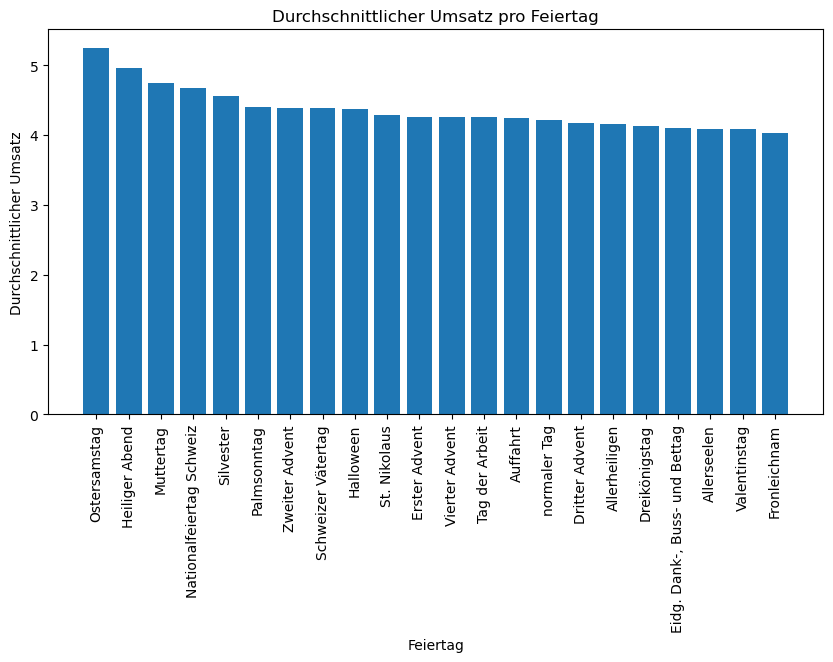

In [1032]:
#erstelle einen Plot für den durchschnittlichen Umsatz pro Feiertag

plt.figure(figsize= (10, 5))
plt.bar(data.groupby("Feiertag Name")["Umsatz"].mean().sort_values(ascending = False).index, data.groupby("Feiertag Name")["Umsatz"].mean().sort_values(ascending = False))
plt.title("Durchschnittlicher Umsatz pro Feiertag")
plt.xlabel("Feiertag")
plt.ylabel("Durchschnittlicher Umsatz")
plt.xticks(rotation = 90)

plt.show()

In [1033]:
#die informationen aus dem plot in eine Tabelle ausgeben
data.groupby("Feiertag Name")["Umsatz"].mean().sort_values(ascending = False).reset_index()


,Feiertag Name,Umsatz
0,Ostersamstag,5.248667
1,Heiliger Abend,4.957025
2,Muttertag,4.742045
3,Nationalfeiertag Schweiz,4.676658
4,Silvester,4.561564
5,Palmsonntag,4.394883
6,Zweiter Advent,4.394153
7,Schweizer Vätertag,4.389930
8,Halloween,4.376063
9,St. Nikolaus,4.291889


In [1034]:
#Einen neuen, leeren Dataframe machen namens "Tag vor Feiertag"
data_vor_feiertag = pd.DataFrame()

#dem neuen Dataframe die Spalten "Datum" und "Vortag von" zuweisen
data_vor_feiertag["Datum"] = ""
data_vor_feiertag["Vortag von"] = ""

#Die Spalte "Datum" soll in den Datentyp "datetime" konvertiert werden
data_vor_feiertag["Datum"] = pd.to_datetime(data_vor_feiertag["Datum"]).dt.date

#für die Datum spalte im dataframe "data_vor_feiertag" soll der Vortag von jedem Feiertag aus dem holidays_df eingetragen werden
i = len(holidays_df)

while i > 0:
    data_vor_feiertag.at[i-1, "Datum"] = holidays_df.at[i-1, "Holiday_Datum"] - pd.Timedelta(days=1)
    data_vor_feiertag.at[i-1, "Vortag von"] = holidays_df.at[i-1, "Feiertag Name"]
    i = i - 1

#Die Daten sollen zum Format YYYY-MM-DD konvertiert werden
data_vor_feiertag["Datum"] = pd.to_datetime(data_vor_feiertag["Datum"]).dt.strftime('%Y-%m-%d')

#in jeden Eintrag mit "Vortag von" soll der Wert "Vortag" beigefügt werden vor dem Feiertag
data_vor_feiertag["Vortag von"] = data_vor_feiertag["Vortag von"].apply(lambda x: "Vortag " + x)

# Create a list of "Datum" dates
datum_dates = data_vor_feiertag['Datum'].tolist()

data_vor_feiertag.head()

,Datum,Vortag von
181,2022-02-13,Vortag Valentinstag
180,2022-01-05,Vortag Dreikönigstag
179,2022-01-01,Vortag Berchtoldstag
178,2021-12-31,Vortag Neujahrstag
177,2021-12-30,Vortag Silvester


In [1035]:
# Nun soll dem Datensatz eine weitere Spalte "Vorfeiertag" eingefügt werden

data['Vortag von'] = ''

#If the date is in the list of holiday dates, then fill this new column with the name of the holiday from the holidays_df dataframe

for index, row in data.iterrows():
    if row['Datum'].strftime('%Y-%m-%d') in datum_dates:
        data.at[index, 'Vortag von'] = data_vor_feiertag.loc[data_vor_feiertag['Datum'] == row['Datum'].strftime('%Y-%m-%d'), 'Vortag von'].values[0]
    else:
        data.at[index, 'Vortag von'] = 'normaler Tag'

# Print the first 5 rows of the dataframe
data.head()

,Artikel,Menge,Umsatz,Bestellungen,Niederschlag,Temperatur Schnitt Tag,Niederschlag Summe Tag,Globalstrahlung Schnitt Tag,Uhrzeit,Stunde,Datum,Wochentag,Monat,Stückpreis,Feiertag Name,Vortag von
0,Butterzopf mittel,1.0,6.0,0.0,0.0,NaN,0.0,NaN,08:01:46,8,2016-01-03,Sunday,1,6.00,normaler Tag,normaler Tag
1,Buttergipfeli,2.0,2.6,0.0,0.0,NaN,0.0,NaN,08:04:45,8,2016-01-03,Sunday,1,1.30,normaler Tag,normaler Tag
2,Buttergipfeli,12.0,15.6,0.0,0.0,NaN,0.0,NaN,08:09:21,8,2016-01-03,Sunday,1,1.30,normaler Tag,normaler Tag
3,Butterzopf mittel,1.0,6.0,0.0,0.0,NaN,0.0,NaN,08:11:19,8,2016-01-03,Sunday,1,6.00,normaler Tag,normaler Tag
4,Buttergipfeli,4.0,5.2,0.0,0.0,NaN,0.0,NaN,08:11:19,8,2016-01-03,Sunday,1,1.30,normaler Tag,normaler Tag


### 2.3.1 Schulferien

In [1036]:
import datetime
erstes_datum = data['Datum'].min()
letztes_datum = data['Datum'].max()

print("Das erste Datum im Datensatz ist:", erstes_datum)
print("Das letzte Datum im Datensatz ist:", letztes_datum)

# Daten von https://av.tg.ch/public/upload/assets/8713/10_Jahresplan_Schulferien_Volksschule_2019_-_2029.pdf?fp=3
# Daten von https://www.schulferien.org/schweiz/kalender/thurgau/2019/

# Ferienlisten nach Ferienzeit erstellen
data['Ferienzeit TG'] = ''

gesamtliste_herbstferien = []
gesamtliste_weihnachtsferien = []
gesamtliste_sportferien = []
gesamtliste_fruehlingsferien = []
gesamtliste_pfingstferien = []
gesamtliste_sommerferien = []


Das erste Datum im Datensatz ist: 2016-01-03 00:00:00
Das letzte Datum im Datensatz ist: 2022-02-11 00:00:00


#### Schuljahr 2015/ 2016

In [1037]:
# Herbstferien Schuljahr 2015 / 2016
# brauchen wir nicht

# Weihnachtsferien Schuljahr 2015 / 2016
ferienbeginn_weihnachten2015_2016 = datetime.date(2015, 12, 24)
ferienende_weihnachten2015_2016 = datetime.date(2016, 1, 3)

current_date = ferienbeginn_weihnachten2015_2016
weihnachtsferien_tg_sj_2015_2016 = []

while current_date <= ferienende_weihnachten2015_2016:
    weihnachtsferien_tg_sj_2015_2016.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Sportferien Schuljahr 2015 / 2016
ferienbeginn_sport2015_2016 = datetime.date(2016, 2, 1)
ferienende_sport2015_2016 = datetime.date(2016, 2, 7)

current_date = ferienbeginn_sport2015_2016
sportferien_tg_sj_2015_2016 = []

while current_date <= ferienende_sport2015_2016:
    sportferien_tg_sj_2015_2016.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Frühlingsferien Schuljahr 2015 / 2016
ferienbeginn_fruehling2015_2016 = datetime.date(2016, 3, 25)
ferienende_fruehling2015_2016 = datetime.date(2016, 4, 10)

current_date = ferienbeginn_fruehling2015_2016
fruehlingsferien_tg_sj_2015_2016 = []

while current_date <= ferienende_fruehling2015_2016:
    fruehlingsferien_tg_sj_2015_2016.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Pfingstferien Schuljahr 2015 / 2016
ferienbeginn_pfingsten2015_2016 = datetime.date(2016, 5, 5)
ferienende_pfingsten2015_2016 = datetime.date(2016, 5, 16)

current_date = ferienbeginn_pfingsten2015_2016
pfingstferien_tg_sj_2015_2016 = []

while current_date <= ferienende_pfingsten2015_2016:
    pfingstferien_tg_sj_2015_2016.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Sommerferien Schuljahr 2015 / 2016
ferienbeginn_sommer2015_2016 = datetime.date(2016, 7, 11)
ferienende_sommer2015_2016 = datetime.date(2016, 8, 14)

current_date = ferienbeginn_sommer2015_2016
sommerferien_tg_sj_2015_2016 = []

while current_date <= ferienende_sommer2015_2016:
    sommerferien_tg_sj_2015_2016.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)


gesamtliste_weihnachtsferien.extend(weihnachtsferien_tg_sj_2015_2016)
gesamtliste_sportferien.extend(sportferien_tg_sj_2015_2016)
gesamtliste_fruehlingsferien.extend(fruehlingsferien_tg_sj_2015_2016)
gesamtliste_pfingstferien.extend(pfingstferien_tg_sj_2015_2016)
gesamtliste_sommerferien.extend(sommerferien_tg_sj_2015_2016)

#### Schuljahr 2016/ 2017

In [1038]:
# Herbstferien Schuljahr 2016 / 2017
ferienbeginn_herbst2016_2017 = datetime.date(2016, 10, 10)
ferienende_herbst2016_2017 = datetime.date(2016, 10, 23)

current_date = ferienbeginn_herbst2016_2017
herbstferien_tg_sj_2016_2017 = []

while current_date <= ferienende_herbst2016_2017:
    herbstferien_tg_sj_2016_2017.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Weihnachtsferien Schuljahr 2016 / 2017
ferienbeginn_weihnachten2016_2017 = datetime.date(2016, 12, 26)
ferienende_weihnachten2016_2017 = datetime.date(2017, 1, 8)

current_date = ferienbeginn_weihnachten2016_2017
weihnachtsferien_tg_sj_2016_2017 = []

while current_date <= ferienende_weihnachten2016_2017:
    weihnachtsferien_tg_sj_2016_2017.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Sportferien Schuljahr 2016 / 2017
ferienbeginn_sport2016_2017 = datetime.date(2017, 1, 30)
ferienende_sport2016_2017 = datetime.date(2017, 2, 5)

current_date = ferienbeginn_sport2016_2017
sportferien_tg_sj_2016_2017 = []

while current_date <= ferienende_sport2016_2017:
    sportferien_tg_sj_2016_2017.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Frühlingsferien Schuljahr 2016 / 2017
ferienbeginn_fruehling2016_2017 = datetime.date(2017, 4, 3)
ferienende_fruehling2016_2017 = datetime.date(2017, 4, 17)

current_date = ferienbeginn_fruehling2016_2017
fruehlingsferien_tg_sj_2016_2017 = []

while current_date <= ferienende_fruehling2016_2017:
    fruehlingsferien_tg_sj_2016_2017.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Pfingstferien Schuljahr 2016 / 2017
ferienbeginn_pfingsten2016_2017 = datetime.date(2017, 5, 25)
ferienende_pfingsten2016_2017 = datetime.date(2017, 6, 5)

current_date = ferienbeginn_pfingsten2016_2017
pfingstferien_tg_sj_2016_2017 = []

while current_date <= ferienende_pfingsten2016_2017:
    pfingstferien_tg_sj_2016_2017.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Sommerferien Schuljahr 2016 / 2017
ferienbeginn_sommer2016_2017 = datetime.date(2017, 7, 10)
ferienende_sommer2016_2017 = datetime.date(2017, 8, 13)

current_date = ferienbeginn_sommer2016_2017
sommerferien_tg_sj_2016_2017 = []

while current_date <= ferienende_sommer2016_2017:
    sommerferien_tg_sj_2016_2017.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

gesamtliste_herbstferien.extend(herbstferien_tg_sj_2016_2017)
gesamtliste_weihnachtsferien.extend(weihnachtsferien_tg_sj_2016_2017)
gesamtliste_sportferien.extend(sportferien_tg_sj_2016_2017)
gesamtliste_fruehlingsferien.extend(fruehlingsferien_tg_sj_2016_2017)
gesamtliste_pfingstferien.extend(pfingstferien_tg_sj_2016_2017)
gesamtliste_sommerferien.extend(sommerferien_tg_sj_2016_2017)



#### Schuljahr 2017/ 2018

In [1039]:
# Herbstferien Schuljahr 2017 / 2018
ferienbeginn_herbst2017_2018 = datetime.date(2017, 10, 9)
ferienende_herbst2017_2018 = datetime.date(2017, 10, 22)

current_date = ferienbeginn_herbst2017_2018
herbstferien_tg_sj_2017_2018 = []

while current_date <= ferienende_herbst2017_2018:
    herbstferien_tg_sj_2017_2018.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Weihnachtsferien Schuljahr 2017 / 2018
ferienbeginn_weihnachten2017_2018 = datetime.date(2017, 12, 25)
ferienende_weihnachten2017_2018 = datetime.date(2018, 1, 7)

current_date = ferienbeginn_weihnachten2017_2018
weihnachtsferien_tg_sj_2017_2018 = []

while current_date <= ferienende_weihnachten2017_2018:
    weihnachtsferien_tg_sj_2017_2018.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Sportferien Schuljahr 2017 / 2018
ferienbeginn_sport2017_2018 = datetime.date(2018, 1, 29)
ferienende_sport2017_2018 = datetime.date(2018, 2, 4)

current_date = ferienbeginn_sport2017_2018
sportferien_tg_sj_2017_2018 = []

while current_date <= ferienende_sport2017_2018:
    sportferien_tg_sj_2017_2018.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Frühlingsferien Schuljahr 2017 / 2018
ferienbeginn_fruehling2017_2018 = datetime.date(2018, 3, 30)
ferienende_fruehling2017_2018 = datetime.date(2018, 4, 15)

current_date = ferienbeginn_fruehling2017_2018
fruehlingsferien_tg_sj_2017_2018 = []

while current_date <= ferienende_fruehling2017_2018:
    fruehlingsferien_tg_sj_2017_2018.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Pfingstferien Schuljahr 2017 / 2018
ferienbeginn_pfingsten2017_2018 = datetime.date(2018, 5, 10)
ferienende_pfingsten2017_2018 = datetime.date(2018, 5, 21)

current_date = ferienbeginn_pfingsten2017_2018
pfingstferien_tg_sj_2017_2018 = []

while current_date <= ferienende_pfingsten2017_2018:
    pfingstferien_tg_sj_2017_2018.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Sommerferien Schuljahr 2017 / 2018
ferienbeginn_sommer2017_2018 = datetime.date(2018, 7, 9)
ferienende_sommer2017_2018 = datetime.date(2018, 8, 12)

current_date = ferienbeginn_sommer2017_2018
sommerferien_tg_sj_2017_2018 = []

while current_date <= ferienende_sommer2017_2018:
    sommerferien_tg_sj_2017_2018.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

gesamtliste_herbstferien.extend(herbstferien_tg_sj_2017_2018)
gesamtliste_weihnachtsferien.extend(weihnachtsferien_tg_sj_2017_2018)
gesamtliste_sportferien.extend(sportferien_tg_sj_2017_2018)
gesamtliste_fruehlingsferien.extend(fruehlingsferien_tg_sj_2017_2018)
gesamtliste_pfingstferien.extend(pfingstferien_tg_sj_2017_2018)
gesamtliste_sommerferien.extend(sommerferien_tg_sj_2017_2018)

#### Schuljahr 2018/ 2019

In [1040]:
# Herbstferien Schuljahr 2018 / 2019
ferienbeginn_herbst2018_2019 = datetime.date(2018, 10, 8)
ferienende_herbst2018_2019 = datetime.date(2018, 10, 21)

current_date = ferienbeginn_herbst2018_2019
herbstferien_tg_sj_2018_2019 = []

while current_date <= ferienende_herbst2018_2019:
    herbstferien_tg_sj_2018_2019.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Weihnachtsferien Schuljahr 2018 / 2019
ferienbeginn_weihnachten2018_2019 = datetime.date(2018, 12, 24)
ferienende_weihnachten2018_2019 = datetime.date(2019, 1, 6)

current_date = ferienbeginn_weihnachten2018_2019
weihnachtsferien_tg_sj_2018_2019 = []

while current_date <= ferienende_weihnachten2018_2019:
    weihnachtsferien_tg_sj_2018_2019.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Sportferien Schuljahr 2018 / 2019
ferienbeginn_sport2018_2019 = datetime.date(2019, 1, 28)
ferienende_sport2018_2019 = datetime.date(2019, 2, 3)

current_date = ferienbeginn_sport2018_2019
sportferien_tg_sj_2018_2019 = []

while current_date <= ferienende_sport2018_2019:
    sportferien_tg_sj_2018_2019.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Frühlingsferien Schuljahr 2018 / 2019
ferienbeginn_fruehling2018_2019 = datetime.date(2019, 4, 19)
ferienende_fruehling2018_2019 = datetime.date(2019, 4, 22)

current_date = ferienbeginn_fruehling2018_2019
fruehlingsferien_tg_sj_2018_2019 = []

while current_date <= ferienende_fruehling2018_2019:
    fruehlingsferien_tg_sj_2018_2019.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Pfingstferien Schuljahr 2018 / 2019
ferienbeginn_pfingsten2018_2019 = datetime.date(2019, 5, 30)
ferienende_pfingsten2018_2019 = datetime.date(2019, 6, 10)

current_date = ferienbeginn_pfingsten2018_2019
pfingstferien_tg_sj_2018_2019 = []

while current_date <= ferienende_pfingsten2018_2019:
    pfingstferien_tg_sj_2018_2019.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Sommerferien Schuljahr 2018 / 2019
ferienbeginn_sommer2018_2019 = datetime.date(2019, 7, 8)
ferienende_sommer2018_2019 = datetime.date(2019, 8, 11)

current_date = ferienbeginn_sommer2018_2019
sommerferien_tg_sj_2018_2019 = []

while current_date <= ferienende_sommer2018_2019:
    sommerferien_tg_sj_2018_2019.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

gesamtliste_herbstferien.extend(herbstferien_tg_sj_2018_2019)
gesamtliste_weihnachtsferien.extend(weihnachtsferien_tg_sj_2018_2019)
gesamtliste_sportferien.extend(sportferien_tg_sj_2018_2019)
gesamtliste_fruehlingsferien.extend(fruehlingsferien_tg_sj_2018_2019)
gesamtliste_pfingstferien.extend(pfingstferien_tg_sj_2018_2019)
gesamtliste_sommerferien.extend(sommerferien_tg_sj_2018_2019)

#### Schuljahr 2019/ 2020

In [1041]:
# Herbstferien Schuljahr 2019 / 2020
ferienbeginn_herbst2019_2020 = datetime.date(2019, 10, 7)
ferienende_herbst2019_2020 = datetime.date(2019, 10, 20)

current_date = ferienbeginn_herbst2019_2020
herbstferien_tg_sj_2019_2020 = []

while current_date <= ferienende_herbst2019_2020:
    herbstferien_tg_sj_2019_2020.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Weihnachtsferien Schuljahr 2019 / 2020
ferienbeginn_weihnachten2019_2020 = datetime.date(2019, 12, 23)
ferienende_weihnachten2019_2020 = datetime.date(2020, 1, 5)

current_date = ferienbeginn_weihnachten2019_2020
weihnachtsferien_tg_sj_2019_2020 = []

while current_date <= ferienende_weihnachten2019_2020:
    weihnachtsferien_tg_sj_2019_2020.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Sportferien Schuljahr 2019 / 2020
ferienbeginn_sport2019_2020 = datetime.date(2020, 1, 27)
ferienende_sport2019_2020 = datetime.date(2020, 2, 2)

current_date = ferienbeginn_sport2019_2020
sportferien_tg_sj_2019_2020 = []

while current_date <= ferienende_sport2019_2020:
    sportferien_tg_sj_2019_2020.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Frühlingsferien Schuljahr 2019 / 2020
ferienbeginn_fruehling2019_2020 = datetime.date(2020, 3, 30)
ferienende_fruehling2019_2020 = datetime.date(2020, 4, 13)

current_date = ferienbeginn_fruehling2019_2020
fruehlingsferien_tg_sj_2019_2020 = []

while current_date <= ferienende_fruehling2019_2020:
    fruehlingsferien_tg_sj_2019_2020.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Pfingstferien Schuljahr 2019 / 2020
ferienbeginn_pfingsten2019_2020 = datetime.date(2020, 5, 21)
ferienende_pfingsten2019_2020 = datetime.date(2020, 6, 1)

current_date = ferienbeginn_pfingsten2019_2020
pfingstferien_tg_sj_2019_2020 = []

while current_date <= ferienende_pfingsten2019_2020:
    pfingstferien_tg_sj_2019_2020.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Sommerferien Schuljahr 2019 / 2020
ferienbeginn_sommer2019_2020 = datetime.date(2020, 7, 6)
ferienende_sommer2019_2020 = datetime.date(2020, 8, 9)

current_date = ferienbeginn_sommer2019_2020
sommerferien_tg_sj_2019_2020 = []

while current_date <= ferienende_sommer2019_2020:
    sommerferien_tg_sj_2019_2020.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

gesamtliste_herbstferien.extend(herbstferien_tg_sj_2019_2020)
gesamtliste_weihnachtsferien.extend(weihnachtsferien_tg_sj_2019_2020)
gesamtliste_sportferien.extend(sportferien_tg_sj_2019_2020)
gesamtliste_fruehlingsferien.extend(fruehlingsferien_tg_sj_2019_2020)
gesamtliste_pfingstferien.extend(pfingstferien_tg_sj_2019_2020)
gesamtliste_sommerferien.extend(sommerferien_tg_sj_2019_2020)

#### Schuljahr 2020/ 2021

In [1042]:
# Herbstferien Schuljahr 2020 / 2021
ferienbeginn_herbst2020_2021 = datetime.date(2020, 10, 5)
ferienende_herbst2020_2021 = datetime.date(2020, 10, 18)

current_date = ferienbeginn_herbst2020_2021
herbstferien_tg_sj_2020_2021 = []

while current_date <= ferienende_herbst2020_2021:
    herbstferien_tg_sj_2020_2021.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Weihnachtsferien Schuljahr 2020 / 2021
ferienbeginn_weihnachten2020_2021 = datetime.date(2020, 12, 21)
ferienende_weihnachten2020_2021 = datetime.date(2021, 1, 3)

current_date = ferienbeginn_weihnachten2020_2021
weihnachtsferien_tg_sj_2020_2021 = []

while current_date <= ferienende_weihnachten2020_2021:
    weihnachtsferien_tg_sj_2020_2021.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Sportferien Schuljahr 2020 / 2021
ferienbeginn_sport2020_2021 = datetime.date(2021, 2, 1)
ferienende_sport2020_2021 = datetime.date(2021, 2, 7)

current_date = ferienbeginn_sport2020_2021
sportferien_tg_sj_2020_2021 = []

while current_date <= ferienende_sport2020_2021:
    sportferien_tg_sj_2020_2021.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Frühlingsferien Schuljahr 2020 / 2021
ferienbeginn_fruehling2020_2021 = datetime.date(2021, 4, 2)
ferienende_fruehling2020_2021 = datetime.date(2021, 4, 18)

current_date = ferienbeginn_fruehling2020_2021
fruehlingsferien_tg_sj_2020_2021 = []

while current_date <= ferienende_fruehling2020_2021:
    fruehlingsferien_tg_sj_2020_2021.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Pfingstferien Schuljahr 2020 / 2021
ferienbeginn_pfingsten2020_2021 = datetime.date(2021, 5, 13)
ferienende_pfingsten2020_2021 = datetime.date(2021, 5, 24)

current_date = ferienbeginn_pfingsten2020_2021
pfingstferien_tg_sj_2020_2021 = []

while current_date <= ferienende_pfingsten2020_2021:
    pfingstferien_tg_sj_2020_2021.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Sommerferien Schuljahr 2020 / 2021
ferienbeginn_sommer2020_2021 = datetime.date(2021, 7, 12)
ferienende_sommer2020_2021 = datetime.date(2021, 8, 15)

current_date = ferienbeginn_sommer2020_2021
sommerferien_tg_sj_2020_2021 = []

while current_date <= ferienende_sommer2020_2021:
    sommerferien_tg_sj_2020_2021.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

gesamtliste_herbstferien.extend(herbstferien_tg_sj_2020_2021)
gesamtliste_weihnachtsferien.extend(weihnachtsferien_tg_sj_2020_2021)
gesamtliste_sportferien.extend(sportferien_tg_sj_2020_2021)
gesamtliste_fruehlingsferien.extend(fruehlingsferien_tg_sj_2020_2021)
gesamtliste_pfingstferien.extend(pfingstferien_tg_sj_2020_2021)
gesamtliste_sommerferien.extend(sommerferien_tg_sj_2020_2021)

#### Schuljahr 2021/ 2022

In [1043]:
# Herbstferien Schuljahr 2021 / 2022
ferienbeginn_herbst2021_2022 = datetime.date(2021, 10, 11)
ferienende_herbst2021_2022 = datetime.date(2021, 10, 24)

current_date = ferienbeginn_herbst2021_2022
herbstferien_tg_sj_2021_2022 = []

while current_date <= ferienende_herbst2021_2022:
    herbstferien_tg_sj_2021_2022.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Weihnachtsferien Schuljahr 2021 / 2022
ferienbeginn_weihnachten2021_2022 = datetime.date(2021, 12, 20)
ferienende_weihnachten2021_2022 = datetime.date(2022, 1, 2)

current_date = ferienbeginn_weihnachten2021_2022
weihnachtsferien_tg_sj_2021_2022 = []

while current_date <= ferienende_weihnachten2021_2022:
    weihnachtsferien_tg_sj_2021_2022.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Sportferien Schuljahr 2021 / 2022
ferienbeginn_sport2021_2022 = datetime.date(2022, 1, 31)
ferienende_sport2021_2022 = datetime.date(2022, 2, 6)

current_date = ferienbeginn_sport2021_2022
sportferien_tg_sj_2021_2022 = []

while current_date <= ferienende_sport2021_2022:
    sportferien_tg_sj_2021_2022.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# mehr brauchen wir zurzeit nicht

gesamtliste_herbstferien.extend(herbstferien_tg_sj_2021_2022)
gesamtliste_weihnachtsferien.extend(weihnachtsferien_tg_sj_2021_2022)
gesamtliste_sportferien.extend(sportferien_tg_sj_2021_2022)


In [1044]:
print(gesamtliste_herbstferien)
data['Datum'] = pd.to_datetime(data['Datum'])

data.loc[data['Datum'].isin(gesamtliste_herbstferien), 'Ferienzeit TG'] = 'Herbstferien'
data.loc[data['Datum'].isin(gesamtliste_weihnachtsferien), 'Ferienzeit TG'] = 'Weihnachtsferien'
data.loc[data['Datum'].isin(gesamtliste_sportferien), 'Ferienzeit TG'] = 'Sportferien'
data.loc[data['Datum'].isin(gesamtliste_fruehlingsferien), 'Ferienzeit TG'] = 'Frühlingsferien'
data.loc[data['Datum'].isin(gesamtliste_pfingstferien), 'Ferienzeit TG'] = 'Pfingstferien'
data.loc[data['Datum'].isin(gesamtliste_sommerferien), 'Ferienzeit TG'] = 'Sommerferien'

data.head()

['2016-10-10', '2016-10-11', '2016-10-12', '2016-10-13', '2016-10-14', '2016-10-15', '2016-10-16', '2016-10-17', '2016-10-18', '2016-10-19', '2016-10-20', '2016-10-21', '2016-10-22', '2016-10-23', '2017-10-09', '2017-10-10', '2017-10-11', '2017-10-12', '2017-10-13', '2017-10-14', '2017-10-15', '2017-10-16', '2017-10-17', '2017-10-18', '2017-10-19', '2017-10-20', '2017-10-21', '2017-10-22', '2018-10-08', '2018-10-09', '2018-10-10', '2018-10-11', '2018-10-12', '2018-10-13', '2018-10-14', '2018-10-15', '2018-10-16', '2018-10-17', '2018-10-18', '2018-10-19', '2018-10-20', '2018-10-21', '2019-10-07', '2019-10-08', '2019-10-09', '2019-10-10', '2019-10-11', '2019-10-12', '2019-10-13', '2019-10-14', '2019-10-15', '2019-10-16', '2019-10-17', '2019-10-18', '2019-10-19', '2019-10-20', '2020-10-05', '2020-10-06', '2020-10-07', '2020-10-08', '2020-10-09', '2020-10-10', '2020-10-11', '2020-10-12', '2020-10-13', '2020-10-14', '2020-10-15', '2020-10-16', '2020-10-17', '2020-10-18', '2021-10-11', '2021

,Artikel,Menge,Umsatz,Bestellungen,Niederschlag,Temperatur Schnitt Tag,Niederschlag Summe Tag,Globalstrahlung Schnitt Tag,Uhrzeit,Stunde,Datum,Wochentag,Monat,Stückpreis,Feiertag Name,Vortag von,Ferienzeit TG
0,Butterzopf mittel,1.0,6.0,0.0,0.0,NaN,0.0,NaN,08:01:46,8,2016-01-03,Sunday,1,6.00,normaler Tag,normaler Tag,Weihnachtsferien
1,Buttergipfeli,2.0,2.6,0.0,0.0,NaN,0.0,NaN,08:04:45,8,2016-01-03,Sunday,1,1.30,normaler Tag,normaler Tag,Weihnachtsferien
2,Buttergipfeli,12.0,15.6,0.0,0.0,NaN,0.0,NaN,08:09:21,8,2016-01-03,Sunday,1,1.30,normaler Tag,normaler Tag,Weihnachtsferien
3,Butterzopf mittel,1.0,6.0,0.0,0.0,NaN,0.0,NaN,08:11:19,8,2016-01-03,Sunday,1,6.00,normaler Tag,normaler Tag,Weihnachtsferien
4,Buttergipfeli,4.0,5.2,0.0,0.0,NaN,0.0,NaN,08:11:19,8,2016-01-03,Sunday,1,1.30,normaler Tag,normaler Tag,Weihnachtsferien


#### Auswertungen

In [1045]:
data['Datum'].dtype

dtype('<M8[ns]')

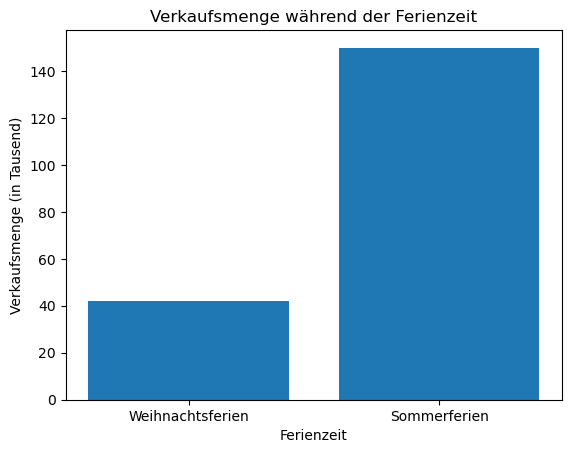

In [1046]:
# Daten für Weihnachtsferien filtern und Menge summieren
weihnachtsferien = data[data['Ferienzeit TG'] == 'Weihnachtsferien']
weihnachtsferien_summe = weihnachtsferien['Menge'].sum() / 1000

# Daten für Sommerferien filtern und Menge summieren
sommerferien = data[data['Ferienzeit TG'] == 'Sommerferien']
sommerferien_summe = sommerferien['Menge'].sum() / 1000

# Balkendiagramm erstellen
ferien = ['Weihnachtsferien', 'Sommerferien']
verkaufsmenge = [weihnachtsferien_summe, sommerferien_summe]

plt.bar(ferien, verkaufsmenge)
plt.xlabel('Ferienzeit')
plt.ylabel('Verkaufsmenge (in Tausend)')
plt.title('Verkaufsmenge während der Ferienzeit')
plt.show()


Obwohl die Sommerferien nur doppelt so lange dauern wie die Winterferien, werden ca. drei Mal so viele Backwaren verkauft.

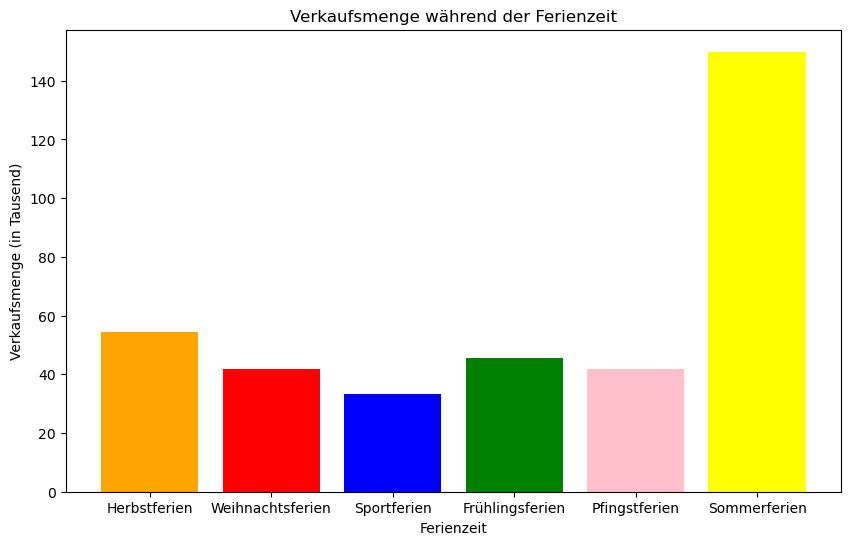

In [1047]:
# Liste der Ferienzeiten
ferienzeiten = ['Herbstferien', 'Weihnachtsferien', 'Sportferien', 'Frühlingsferien', 'Pfingstferien', 'Sommerferien']

# Verkaufsmenge für jede Ferienzeit berechnen
verkaufsmenge = []
for ferienzeit in ferienzeiten:
    ferien = data[data['Ferienzeit TG'] == ferienzeit]
    ferien_summe = ferien['Menge'].sum() / 1000
    verkaufsmenge.append(ferien_summe)

# Farben definieren
farben = ['orange', 'red', 'blue', 'green', 'pink', 'yellow']

# Balkendiagramm erstellen
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(ferienzeiten, verkaufsmenge, color=farben)
ax.set_xlabel('Ferienzeit')
ax.set_ylabel('Verkaufsmenge (in Tausend)')
ax.set_title('Verkaufsmenge während der Ferienzeit')
plt.show()

Man sieht, die Zeit der Sommerferien ist mit Abstand die profitabelste Ferienzeit für die Bäckerei.

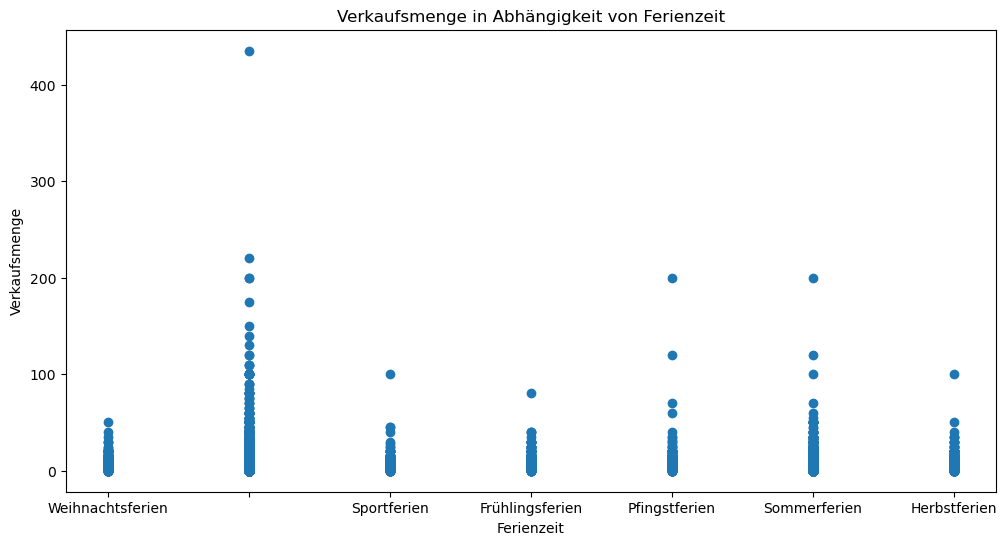

In [1048]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(data['Ferienzeit TG'], data['Menge'])
ax.set_title('Verkaufsmenge in Abhängigkeit von Ferienzeit')
ax.set_xlabel('Ferienzeit')
ax.set_ylabel('Verkaufsmenge')
plt.show()

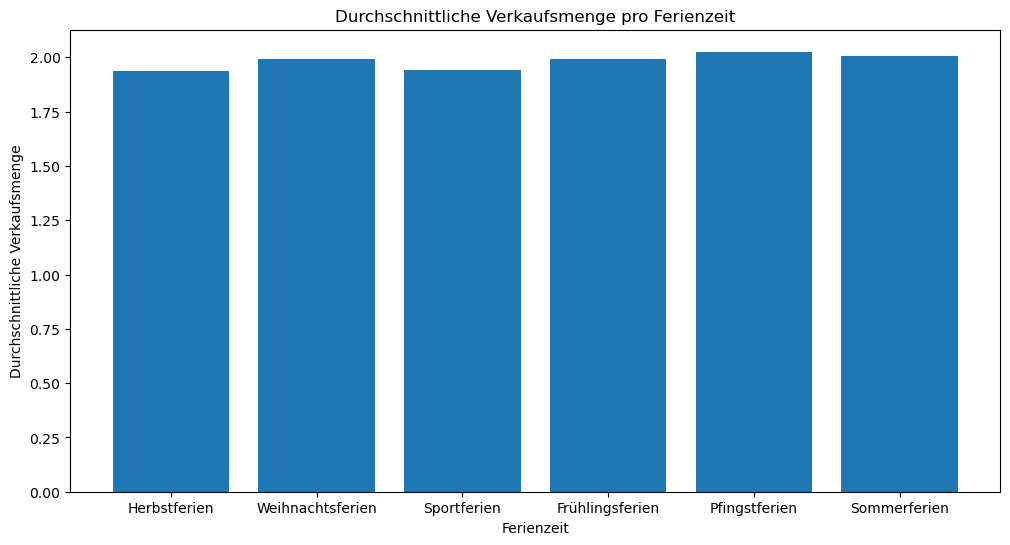

In [1049]:
import pandas as pd
import matplotlib.pyplot as plt


# Umwandeln der Ferienzeit-Spalte in eine kategorische Variable und Festlegen der Sortierung
ferienzeit_order = ["Herbstferien", "Weihnachtsferien", "Sportferien", "Frühlingsferien", "Pfingstferien", "Sommerferien"]
data["Ferienzeit TG"] = pd.Categorical(data["Ferienzeit TG"], categories=ferienzeit_order, ordered=True)

# Gruppieren nach Ferienzeit und Berechnen der durchschnittlichen Verkaufsmenge
grouped_data = data.groupby("Ferienzeit TG")["Menge"].mean()

# Erstellen des Balkendiagramms
plt.figure(figsize=(12, 6))
plt.bar(grouped_data.index, grouped_data.values)
plt.title("Durchschnittliche Verkaufsmenge pro Ferienzeit")
plt.xlabel("Ferienzeit")
plt.ylabel("Durchschnittliche Verkaufsmenge")
plt.show()


### 2.3.2 Süß und Herzhaft

Wir vermuten einen Zusammenhang zwischen verkaufter Menge und ob ein Produkt süß oder herzhaft ist. Eine Hypothese ist hier beispielsweise, dass an manchen Tagen mehr süße Produkte als Herzhafte Produkte verkauft werden. So könnten Kunden vielleicht Montags eher süßes Gebäck kaufen, weil sie gestresst wegen der Arbeit sind. Genauso gut, könnte ein Peak aber auch richtung Wochenende liegen, da viele sich dann eher etwas süßes vom Bäcker gönnen. 

(Anmerkung: Wir haben die Christliche Fastenzeit nur bis Gründonnerstag beschränkt, obwohl sie streng genommen bis Ostersonntag geht. Grund dafür ist, dass viele Gebäck für die Feiertage im Voraus einkaufen)

In [1050]:
# Manuelle Klassifizierung der Produkte in 'süss' und 'herzhaft'
produkte_süß_herzhaft = pd.DataFrame(produkt_liste['Artikel'])
attribute = ['süss', 'herzhaft', 'herzhaft', 'herzhaft', 'herzhaft', 'herzhaft', 'süss', 'süss', 'süss', 'süss', 'süss', 'herzhaft','süss','süss']
produkte_süß_herzhaft['Geschmack'] = attribute
produkte_süß_herzhaft

# Daten mit den manuell klassifizierten Produkten zusammenführen
data = pd.merge(data, produkte_süß_herzhaft, on='Artikel')
data = data.rename(columns={'Geschmack_y': 'Geschmack'})


### 2.3.3 Fastenzeit

Als erstes Fügen wir die Christliche Fastenzeit zum Datensatz hinzu, da wir vermuten, dass einige Menschen in der Fastenzeit zumindest weniger Alkohol und Süßigkeiten konsumieren. 

In [1051]:
import datetime 
start_datum = data["Datum"].min()
end_datum = data["Datum"].max()

# Fastenzeit start und Enddaten zwischen 2015 und 2022
fastenzeit = [
    (datetime.date(2015, 2, 18), datetime.date(2015, 4, 2)),
    (datetime.date(2016, 2, 10), datetime.date(2016, 3, 24)),
    (datetime.date(2017, 3, 1), datetime.date(2017, 4, 16)),
    (datetime.date(2018, 2, 14), datetime.date(2018, 3, 29)),
    (datetime.date(2019, 3, 6), datetime.date(2019, 4, 18)),
    (datetime.date(2020, 2, 26), datetime.date(2020, 4, 9)),
    (datetime.date(2021, 2, 17), datetime.date(2021, 4, 1)),
    (datetime.date(2022, 3, 2), datetime.date(2022, 4, 14)),
]
# Function to check if a date is within Lent period
def is_lent(date):
    for start, end in fastenzeit:
        if start <= date.date() <= end:

        
            return 1
    return 0

# Anwendung der Funktion auf die Daten und Erstellung einer neuen Spalte
data['Fastenzeit'] = data['Datum'].apply(is_lent)


Als nächstes fügen wir eine Spalte hinzu die sagt, ob ein Verkauf während des Ramadhans stattgefunden hat. Wir vermuten hier einen Zusammenhang mit den Verkäufen, da sich auch eine Muslimische Gemeinde in der Nähe der Filiale befindet

In [1052]:
# Ramadan Start und Enddaten zwischen 2015 und 2022
import datetime 
Ramadan = [
    (datetime.date(2015, 6, 17), datetime.date(2015, 7, 16)),
    (datetime.date(2016, 6, 6), datetime.date(2016, 7, 5)),
    (datetime.date(2017, 5, 26), datetime.date(2017, 6, 24)),
    (datetime.date(2018, 5, 16), datetime.date(2018, 6, 14)),
    (datetime.date(2019, 5, 5), datetime.date(2019, 6, 3)),
    (datetime.date(2020, 4, 23), datetime.date(2020, 5, 23)),
    (datetime.date(2021, 4, 12), datetime.date(2021, 5, 12)),
    (datetime.date(2022, 4, 1), datetime.date(2022, 5, 1)),
]

# Function to check if a date is within Ramadan period
def is_ramadan(date):
    for start, end in Ramadan:
        if start <= date.date() <= end:

       

            return 1
    return 0

# Anwendung der Funktion auf die Daten und Erstellung einer neuen Spalte
data['Ramadan'] = data['Datum'].apply(is_ramadan)

In [1053]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 719678 entries, 0 to 719677
Data columns (total 20 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Artikel                      719678 non-null  object        
 1   Menge                        719678 non-null  float64       
 2   Umsatz                       719678 non-null  float64       
 3   Bestellungen                 719678 non-null  float64       
 4   Niederschlag                 717181 non-null  float64       
 5   Temperatur Schnitt Tag       711720 non-null  float64       
 6   Niederschlag Summe Tag       719678 non-null  float64       
 7   Globalstrahlung Schnitt Tag  711720 non-null  float64       
 8   Uhrzeit                      719678 non-null  object        
 9   Stunde                       719678 non-null  int64         
 10  Datum                        719678 non-null  datetime64[ns]
 11  Wochentag                 

# 6. Forecasting Modelle

## 6.1 Vorbereitungen

Bevor wir Forecasting Modelle anwenden können müssen wir noch den Datensatz tageweise zusammenfassen

In [1054]:
# Löschen der Zeilen mit Werten über 20 in der Spalte 'butterzopf_mittel'
#data_prep = data_prep.loc[data_prep['butterzopf_mittel'] > 20, 'butterzopf_mittel'] = None

In [1055]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 719678 entries, 0 to 719677
Data columns (total 20 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Artikel                      719678 non-null  object        
 1   Menge                        719678 non-null  float64       
 2   Umsatz                       719678 non-null  float64       
 3   Bestellungen                 719678 non-null  float64       
 4   Niederschlag                 717181 non-null  float64       
 5   Temperatur Schnitt Tag       711720 non-null  float64       
 6   Niederschlag Summe Tag       719678 non-null  float64       
 7   Globalstrahlung Schnitt Tag  711720 non-null  float64       
 8   Uhrzeit                      719678 non-null  object        
 9   Stunde                       719678 non-null  int64         
 10  Datum                        719678 non-null  datetime64[ns]
 11  Wochentag                 

In [1056]:
# Verschiedene Werte in Spalte 'Ferienzeit TG'
data['Ferienzeit TG'].unique()

['Weihnachtsferien', NaN, 'Sportferien', 'Frühlingsferien', 'Pfingstferien', 'Sommerferien', 'Herbstferien']
Categories (6, object): ['Herbstferien' < 'Weihnachtsferien' < 'Sportferien' < 'Frühlingsferien' < 'Pfingstferien' < 'Sommerferien']

In [1057]:
# Add 'Keine Ferienzeit' as a new category to 'Ferienzeit TG' column
data['Ferienzeit TG'] = data['Ferienzeit TG'].cat.add_categories(['Keine Ferienzeit'])

# Fill missing values with the new category
data['Ferienzeit TG'] = data['Ferienzeit TG'].fillna('Keine Ferienzeit')

In [1060]:
# Droppen von Spalten, die nicht zur Regression beitragen
data_prep = data.drop(['Stückpreis', 'Wochentag', 'Umsatz', 'Niederschlag', 'Uhrzeit', 'Stunde', 'Feiertag Name'], axis = 1)
data_prep = pd.get_dummies(data_prep, columns = ['Ferienzeit TG', 'Geschmack', 'Vortag von'])
data_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 719678 entries, 0 to 719677
Data columns (total 46 columns):
 #   Column                                           Non-Null Count   Dtype         
---  ------                                           --------------   -----         
 0   Artikel                                          719678 non-null  object        
 1   Menge                                            719678 non-null  float64       
 2   Bestellungen                                     719678 non-null  float64       
 3   Temperatur Schnitt Tag                           711720 non-null  float64       
 4   Niederschlag Summe Tag                           719678 non-null  float64       
 5   Globalstrahlung Schnitt Tag                      711720 non-null  float64       
 6   Datum                                            719678 non-null  datetime64[ns]
 7   Monat                                            719678 non-null  int64         
 8   Fastenzeit              

In [1061]:
# Entfernen von Missing Values außer in Dummies
data_prep = data_prep.dropna()
data_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 711720 entries, 520 to 719677
Data columns (total 46 columns):
 #   Column                                           Non-Null Count   Dtype         
---  ------                                           --------------   -----         
 0   Artikel                                          711720 non-null  object        
 1   Menge                                            711720 non-null  float64       
 2   Bestellungen                                     711720 non-null  float64       
 3   Temperatur Schnitt Tag                           711720 non-null  float64       
 4   Niederschlag Summe Tag                           711720 non-null  float64       
 5   Globalstrahlung Schnitt Tag                      711720 non-null  float64       
 6   Datum                                            711720 non-null  datetime64[ns]
 7   Monat                                            711720 non-null  int64         
 8   Fastenzeit            

In [1062]:
data_prep.head()

,Artikel,Menge,Bestellungen,Temperatur Schnitt Tag,Niederschlag Summe Tag,Globalstrahlung Schnitt Tag,Datum,Monat,Fastenzeit,Ramadan,...,Vortag von_Vortag Schweizer Vätertag,Vortag von_Vortag Silvester,Vortag von_Vortag St. Nikolaus,Vortag von_Vortag Stephanstag,Vortag von_Vortag Tag der Arbeit,Vortag von_Vortag Valentinstag,Vortag von_Vortag Vierter Advent,Vortag von_Vortag Weihnachten,Vortag von_Vortag Zweiter Advent,Vortag von_normaler Tag
520,Butterzopf mittel,1.0,0.0,5.245833,1.8,39.166667,2016-02-05,2,0,0,...,0,0,0,0,0,0,0,0,0,1
521,Butterzopf mittel,1.0,0.0,5.245833,1.8,39.166667,2016-02-05,2,0,0,...,0,0,0,0,0,0,0,0,0,1
522,Butterzopf mittel,1.0,0.0,5.245833,1.8,39.166667,2016-02-05,2,0,0,...,0,0,0,0,0,0,0,0,0,1
523,Butterzopf mittel,1.0,0.0,5.245833,1.8,39.166667,2016-02-05,2,0,0,...,0,0,0,0,0,0,0,0,0,1
524,Butterzopf mittel,1.0,0.0,5.245833,1.8,39.166667,2016-02-05,2,0,0,...,0,0,0,0,0,0,0,0,0,1


In [1063]:
# One-Hot-Encoding für die Spalte "Artikel"
#data_prep = pd. get_dummies (data_prep, columns = [ 'Artikel' ])

# Gruppieren der Daten nach Datum und berechnen der Summe der Menge pro Artikel
sum_cols = ['Menge', 'Bestellungen']

mean_cols = ['Temperatur Schnitt Tag','Niederschlag Summe Tag', 
             'Globalstrahlung Schnitt Tag', 'Fastenzeit','Ramadan']

for col in data_prep.columns:
    if col.startswith(('Ferienzeit', 'Geschmack', 'Feiertag', 'Vortag von')):
        mean_cols.append(col)

agg_dict = {col: 'sum' for col in sum_cols}
agg_dict.update({col: 'mean' for col in mean_cols})

data_prep = data_prep.groupby(['Datum', 'Artikel']).agg(agg_dict).reset_index()

# Ersetzen der Leerzeichen in Artikel mit Unterstrich
data_prep['Artikel'] = data_prep['Artikel'].str.replace(' ', '_')
data_prep = data_prep.drop('Datum', axis = 1)
data_prep.head()


,Artikel,Menge,Bestellungen,Temperatur Schnitt Tag,Niederschlag Summe Tag,Globalstrahlung Schnitt Tag,Fastenzeit,Ramadan,Ferienzeit TG_Herbstferien,Ferienzeit TG_Weihnachtsferien,...,Vortag von_Vortag Schweizer Vätertag,Vortag von_Vortag Silvester,Vortag von_Vortag St. Nikolaus,Vortag von_Vortag Stephanstag,Vortag von_Vortag Tag der Arbeit,Vortag von_Vortag Valentinstag,Vortag von_Vortag Vierter Advent,Vortag von_Vortag Weihnachten,Vortag von_Vortag Zweiter Advent,Vortag von_normaler Tag
0,BT_Nussgipfel,14.0,0.0,3.890909,1.6,12.636364,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Buttergipfeli,131.0,0.0,3.890909,1.6,12.636364,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,Crèmeschnitten,28.0,0.0,3.890909,1.6,12.636364,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,Hefe-Vanille-Weggli,13.0,0.0,3.890909,1.6,12.636364,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,Il_pollo_forte_gefüllt,20.0,0.0,3.890909,1.6,12.636364,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [1064]:
# Splitten des Datensets in Datasets für die einzelnen Artikel mit einer for-schleife

dataframes = [data_prep[data_prep['Artikel'] == i] for i in data_prep['Artikel'].unique()]

In [1065]:
data_prep.reset_index(drop=True, inplace=True)
data_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27856 entries, 0 to 27855
Data columns (total 44 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Artikel                                          27856 non-null  object 
 1   Menge                                            27856 non-null  float64
 2   Bestellungen                                     27856 non-null  float64
 3   Temperatur Schnitt Tag                           27856 non-null  float64
 4   Niederschlag Summe Tag                           27856 non-null  float64
 5   Globalstrahlung Schnitt Tag                      27856 non-null  float64
 6   Fastenzeit                                       27856 non-null  float64
 7   Ramadan                                          27856 non-null  float64
 8   Ferienzeit TG_Herbstferien                       27856 non-null  float64
 9   Ferienzeit TG_Weihnachtsferi

In [1066]:
data_prep.head()

,Artikel,Menge,Bestellungen,Temperatur Schnitt Tag,Niederschlag Summe Tag,Globalstrahlung Schnitt Tag,Fastenzeit,Ramadan,Ferienzeit TG_Herbstferien,Ferienzeit TG_Weihnachtsferien,...,Vortag von_Vortag Schweizer Vätertag,Vortag von_Vortag Silvester,Vortag von_Vortag St. Nikolaus,Vortag von_Vortag Stephanstag,Vortag von_Vortag Tag der Arbeit,Vortag von_Vortag Valentinstag,Vortag von_Vortag Vierter Advent,Vortag von_Vortag Weihnachten,Vortag von_Vortag Zweiter Advent,Vortag von_normaler Tag
0,BT_Nussgipfel,14.0,0.0,3.890909,1.6,12.636364,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Buttergipfeli,131.0,0.0,3.890909,1.6,12.636364,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,Crèmeschnitten,28.0,0.0,3.890909,1.6,12.636364,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,Hefe-Vanille-Weggli,13.0,0.0,3.890909,1.6,12.636364,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,Il_pollo_forte_gefüllt,20.0,0.0,3.890909,1.6,12.636364,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [1067]:
pre_optimized = data_prep.copy()

### Optimierung

In [1068]:
# Für Butterzopf_mittel: Berechnung der minimalen und maximalen Menge, sowie der Gesamtsumme der Menge
butterzopf_mittel = pre_optimized[data_prep['Artikel'] == 'Butterzopf_mittel']
print(butterzopf_mittel['Menge'].describe())
print('Summe: ', butterzopf_mittel['Menge'].sum())
print('Median: ', butterzopf_mittel['Menge'].median())

count    1975.000000
mean       31.604051
std        32.702989
min         1.000000
25%         7.000000
50%        15.000000
75%        57.000000
max       312.000000
Name: Menge, dtype: float64
Summe:  62418.0
Median:  15.0


Beim Butterzopf ist auffällig, dass bei einer relativ geringen Menge (16% von Verkaufsmenge Buttergipfel) eine hohe Variation in den gekauften Mengen besteht. Das erkennt man besonders daran, dass der Durchschnitt bei 31.6 liegt, während der Median nur bei 15 liegt.

Um dem entgegenzuwirken entfernen wir Werte größer 20, da wir davon ausgehen, dass solch große Mengen nicht ohne Voranküdigung gekauft werden. Und wenn der Kauf vorbestellt ist, dann ist er auch nicht mehr für unsere Prediciton relevant.

In [1069]:
# For schleife, die durch alle Artikel iteriert und die Zeile löscht, wenn der Artikel 'butteropf Mittel' größer als 20 ist
#for i in range(len(data_prep)):
#    if data_prep['Artikel'][i] == 'Butterzopf_mittel' and data_prep['Menge'][i] > 20:
#        data_prep.drop(i, inplace = True)

#data_prep.info()

## 6.2 Lineare Regression

In [1070]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

In [1071]:
def LinReg_train_and_evaluate_product_model(data, product_id):
    # Filter the data for the specific product
    product_data = data[data['Artikel'] == product_id]
    
    # Split the data into features (X) and target (y)
    X = product_data.drop(['Menge', 'Artikel'], axis=1)
    y = product_data['Menge']
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Define the XGBoost model
    model = LinearRegression()
    
    # Train the model on the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the testing data
    y_pred = model.predict(X_test)
    
    # Calculate the mean squared error of the model
    MAPE = mean_absolute_percentage_error(y_test, y_pred)
    R2 = model.score(X_test, y_test)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return MAPE, R2, RMSE


In [1072]:
LinReg_train_and_evaluate_product_model(data_prep, 'Buttergipfeli')

(0.23102734698992836, 0.4887705386642288, 56.39523916614758)

In [1073]:
linReg_Artikel = []  # Create an empty list to store the models

metric_names = ['MAPE', 'R2', 'RMSE']  # Add more metric names if there are more than 3 returned values

for product in data_prep['Artikel'].unique():
    model_metrics = LinReg_train_and_evaluate_product_model(data_prep, product)
    model_metrics_dict = {'Type': 'LinReg', 'product': product, **dict(zip(metric_names, model_metrics))}
    linReg_Artikel.append(model_metrics_dict)

# Visualize the results
linReg_Artikel = pd.DataFrame(linReg_Artikel)
linReg_Artikel

,Type,product,MAPE,R2,RMSE
0,LinReg,BT_Nussgipfel,0.262727,0.472047,10.301509
1,LinReg,Buttergipfeli,0.231027,0.488771,56.395239
2,LinReg,Crèmeschnitten,0.311112,0.721260,11.548925
3,LinReg,Hefe-Vanille-Weggli,0.256981,0.777165,4.370407
4,LinReg,Il_pollo_forte_gefüllt,0.159996,0.671444,3.084070
5,LinReg,Laugenbrötli,0.226687,0.573223,11.638611
6,LinReg,Laugengi.mit_SoBlu,0.203696,0.650312,19.746263
7,LinReg,Maisgipfel,0.240854,0.672727,18.852270
8,LinReg,Quarkzöpfli,0.192755,0.696454,4.762058
9,LinReg,Schoggibrötli,0.422063,0.830566,6.821888


In [1074]:
# Extrahieren von MAPE aus dem Dataframe
LinReg_Artikel_MAPE = linReg_Artikel[['product', 'MAPE']]
LinReg_Artikel_MAPE

,product,MAPE
0,BT_Nussgipfel,0.262727
1,Buttergipfeli,0.231027
2,Crèmeschnitten,0.311112
3,Hefe-Vanille-Weggli,0.256981
4,Il_pollo_forte_gefüllt,0.159996
5,Laugenbrötli,0.226687
6,Laugengi.mit_SoBlu,0.203696
7,Maisgipfel,0.240854
8,Quarkzöpfli,0.192755
9,Schoggibrötli,0.422063


In [1075]:
# Visualisieren der Ergebnisse
import matplotlib.pyplot as plt
import seaborn as sns


## 6.3 XGBoost Regressor

In [1076]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [1077]:
buttergipfel = data_prep[data_prep['Artikel'] == 'Buttergipfeli']
buttergipfel.head()

# Splitten des Datensets in Trainings- und Testdaten
X = buttergipfel.drop(['Menge', 'Artikel'], axis=1)
y = buttergipfel['Menge']

X_buttergipfel_train, X_buttergipfel_test, y_buttergipfel_train, y_buttergipfel_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Erstellen des Modells
model_Buttergipfeli_xgb = xgb.XGBRegressor(objective ='reg:squarederror')

# Trainieren des Modells
model_Buttergipfeli_xgb.fit(X_buttergipfel_train, y_buttergipfel_train)

# Vorhersagen mit dem Modell
y_buttergipfel_pred = model.predict(X_buttergipfel_test)

# Berechnen des MAPE
mape = mean_absolute_percentage_error(y_buttergipfel_test, y_buttergipfel_pred)
print('MAPE: %.3f' % mape)

ValueError: Feature shape mismatch, expected: 37, got 42

In [1078]:
def XGB_train_and_evaluate_product_model(data, product_id):
    # Filter the data for the specific product
    product_data = data[data['Artikel'] == product_id]
    
    # Split the data into features (X) and target (y)
    X = product_data.drop(['Menge', 'Artikel'], axis=1)
    y = product_data['Menge']
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Define the XGBoost model
    model = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1)
    
    # Train the model on the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the testing data
    y_pred = model.predict(X_test)
    
    # Calculate the mean squared error of the model
    MAPE = mean_absolute_percentage_error(y_test, y_pred)
    R2 = model.score(X_test, y_test)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return MAPE, R2, RMSE


In [1079]:
xgb_Artikel = []  # Create an empty list to store the models

metric_names = ['MAPE', 'R2', 'RMSE']  # Add more metric names if there are more than 3 returned values

for product in data_prep['Artikel'].unique():
    model_metrics = XGB_train_and_evaluate_product_model(data_prep, product)
    model_metrics_dict = {'Type': 'XGBoost', 'product': product, **dict(zip(metric_names, model_metrics))}
    xgb_Artikel.append(model_metrics_dict)

# Visualize the results
xgb_Artikel = pd.DataFrame(xgb_Artikel)
xgb_Artikel


,Type,product,MAPE,R2,RMSE
0,XGBoost,BT_Nussgipfel,0.299085,0.423934,10.760672
1,XGBoost,Buttergipfeli,0.200926,0.553110,52.727231
2,XGBoost,Crèmeschnitten,0.286742,0.699193,11.997370
3,XGBoost,Hefe-Vanille-Weggli,0.233394,0.801839,4.121343
4,XGBoost,Il_pollo_forte_gefüllt,0.132592,0.739651,2.745352
5,XGBoost,Laugenbrötli,0.203870,0.631607,10.813249
6,XGBoost,Laugengi.mit_SoBlu,0.206269,0.676154,19.002637
7,XGBoost,Maisgipfel,0.223279,0.708088,17.804684
8,XGBoost,Quarkzöpfli,0.182830,0.745585,4.359677
9,XGBoost,Schoggibrötli,0.396112,0.861676,6.163871


In [1080]:
# Extrahieren von MAPE aus dem Dataframe
xgb_Artikel_MAPE = xgb_Artikel[['product', 'MAPE']]
xgb_Artikel_MAPE

,product,MAPE
0,BT_Nussgipfel,0.299085
1,Buttergipfeli,0.200926
2,Crèmeschnitten,0.286742
3,Hefe-Vanille-Weggli,0.233394
4,Il_pollo_forte_gefüllt,0.132592
5,Laugenbrötli,0.203870
6,Laugengi.mit_SoBlu,0.206269
7,Maisgipfel,0.223279
8,Quarkzöpfli,0.182830
9,Schoggibrötli,0.396112


## 6.5 Vergleich der Modelle

In [1081]:
# Verbinden der beiden Dataframes
Artikel_MAPE = pd.merge(LinReg_Artikel_MAPE, xgb_Artikel_MAPE, on='product')

# Umbenennen der Spalten
Artikel_MAPE.columns = ['Artikel', 'Lineare Regression', 'XGB']
Artikel_MAPE

,Artikel,Lineare Regression,XGB
0,BT_Nussgipfel,0.262727,0.299085
1,Buttergipfeli,0.231027,0.200926
2,Crèmeschnitten,0.311112,0.286742
3,Hefe-Vanille-Weggli,0.256981,0.233394
4,Il_pollo_forte_gefüllt,0.159996,0.132592
5,Laugenbrötli,0.226687,0.203870
6,Laugengi.mit_SoBlu,0.203696,0.206269
7,Maisgipfel,0.240854,0.223279
8,Quarkzöpfli,0.192755,0.182830
9,Schoggibrötli,0.422063,0.396112


In [1082]:
# Berechnen des MAPE-Differenz
Artikel_MAPE['MAPE Diff XGB'] = Artikel_MAPE['XGB'] - Artikel_MAPE['Lineare Regression']
Artikel_MAPE.round(4)

,Artikel,Lineare Regression,XGB,MAPE Diff XGB
0,BT_Nussgipfel,0.2627,0.2991,0.0364
1,Buttergipfeli,0.2310,0.2009,-0.0301
2,Crèmeschnitten,0.3111,0.2867,-0.0244
3,Hefe-Vanille-Weggli,0.2570,0.2334,-0.0236
4,Il_pollo_forte_gefüllt,0.1600,0.1326,-0.0274
5,Laugenbrötli,0.2267,0.2039,-0.0228
6,Laugengi.mit_SoBlu,0.2037,0.2063,0.0026
7,Maisgipfel,0.2409,0.2233,-0.0176
8,Quarkzöpfli,0.1928,0.1828,-0.0099
9,Schoggibrötli,0.4221,0.3961,-0.0260


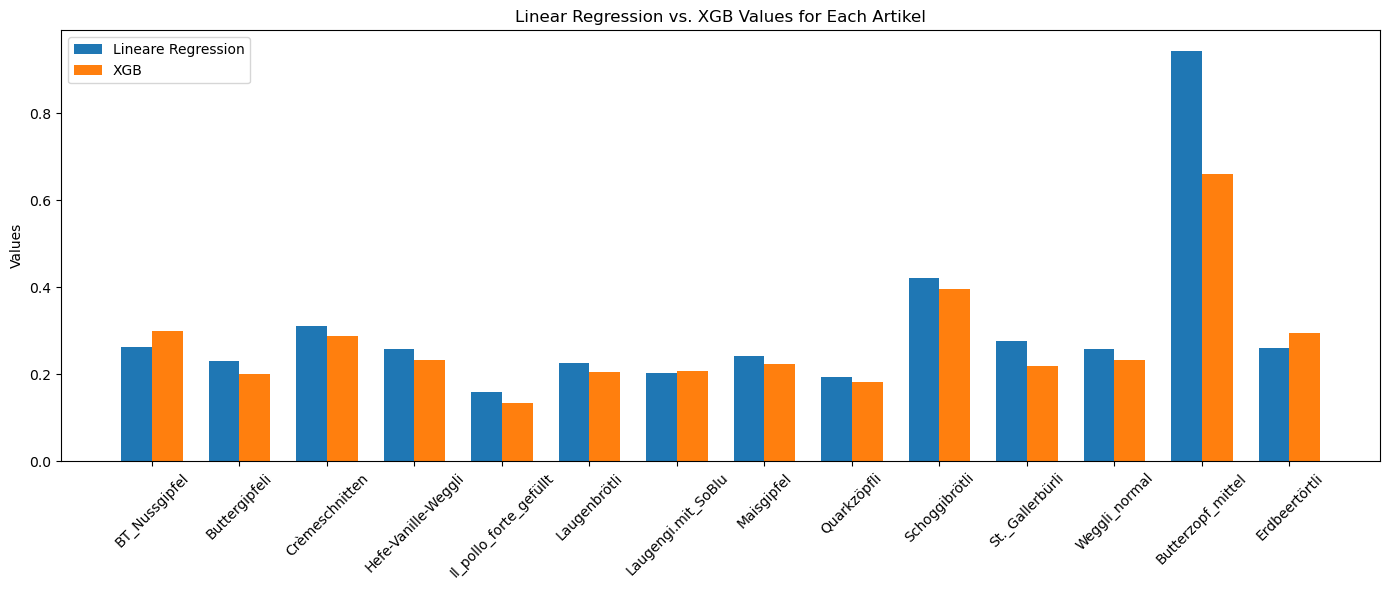

In [1083]:
bar_width = 0.35

# Positions of the bars on the x-axis
ind = np.arange(len(Artikel_MAPE['Artikel']))

# Figure size
plt.figure(figsize=(14, 6))

# Create bars
plt.bar(ind, Artikel_MAPE['Lineare Regression'], width=bar_width, label='Lineare Regression')
plt.bar(ind + bar_width, Artikel_MAPE['XGB'], width=bar_width, label='XGB')

# Set x-axis labels and ticks
plt.xticks(ind + bar_width / 2, Artikel_MAPE['Artikel'], rotation=45)

# Set y-axis label
plt.ylabel('Values')

# Set plot title
plt.title('Linear Regression vs. XGB Values for Each Artikel')

# Add legend
plt.legend(loc='best')

# Show plot
plt.tight_layout()
plt.show()

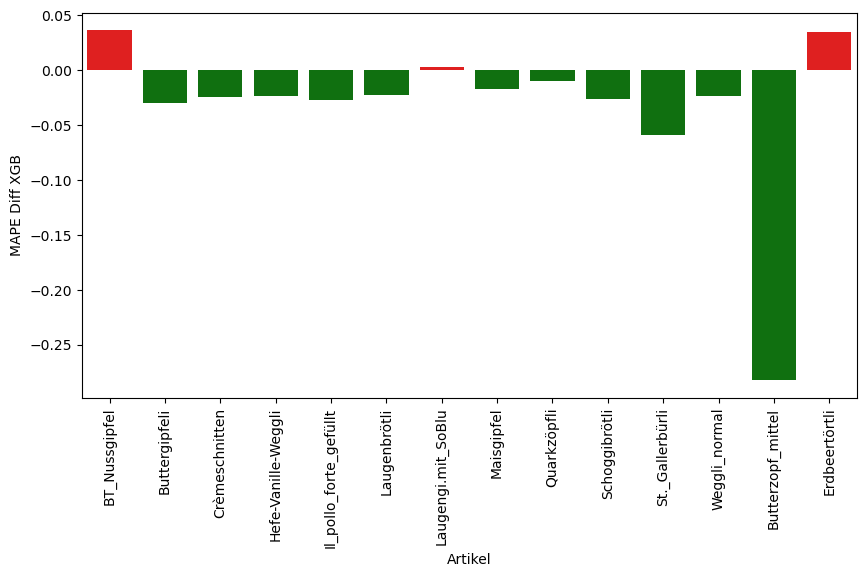

In [1084]:
import matplotlib.pyplot as plt
import seaborn as sns

def custom_palette(values):
    palette = []
    for value in values:
        if value >= 0:
            palette.append('red')
        else:
            palette.append('green')
    return palette

plt.figure(figsize=(10, 5))

# Extract MAPE Diff XGB values for the custom_palette function
mape_diff_values = Artikel_MAPE['MAPE Diff XGB'].values

# Use the custom palette with the sns.barplot function
sns.barplot(x='Artikel', y='MAPE Diff XGB', data=Artikel_MAPE, palette=custom_palette(mape_diff_values))

plt.xticks(rotation=90)
plt.show()


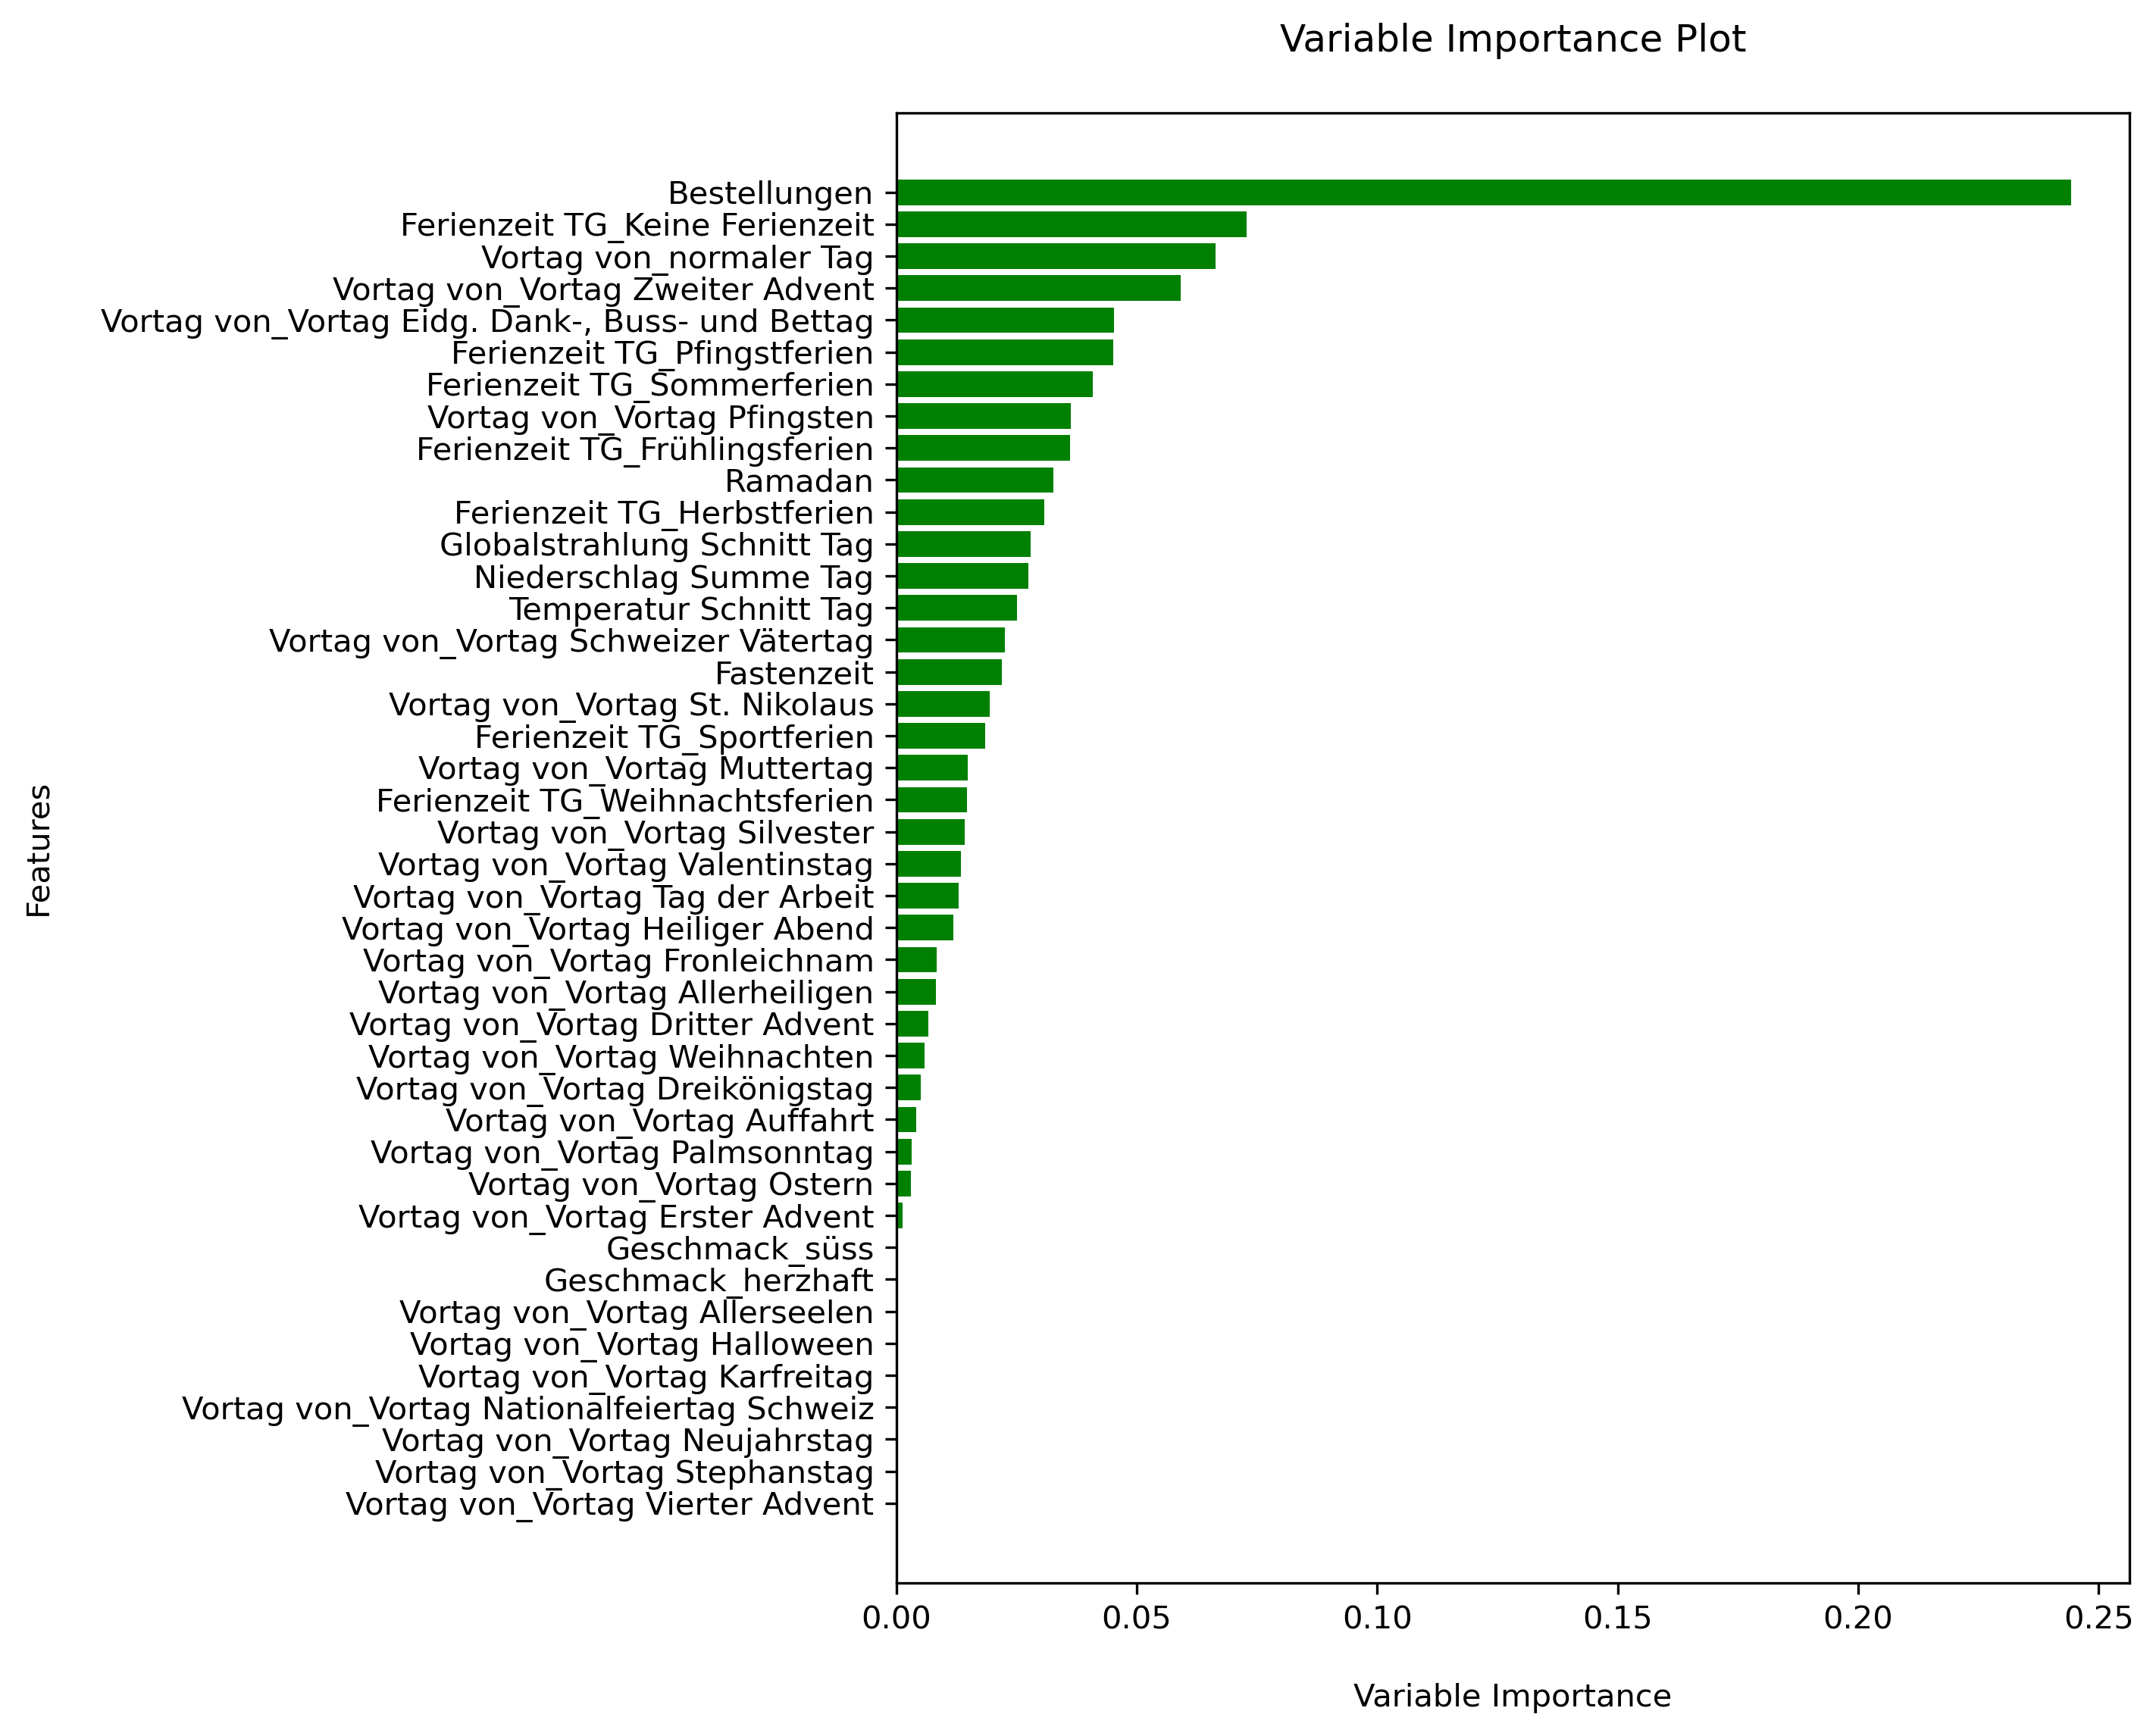

In [1085]:
def plot_variable_importance(model_Buttergipfeli_xgb, X_buttergipfel_train):
    import matplotlib.pyplot as plt
    from pandas import DataFrame
    imp=DataFrame({"imp":model_Buttergipfeli_xgb.feature_importances_, "names":X_buttergipfel_train.columns}).sort_values("imp", ascending=True)
    fig, ax = plt.subplots(figsize=(imp.shape[0]/6,imp.shape[0]/5), dpi=300) 
    ax.barh(imp["names"],imp["imp"], color="green") 
    ax.set_xlabel('\nVariable Importance')
    ax.set_ylabel('Features\n') 
    ax.set_title('Variable Importance Plot\n') 
    plt.show() 
plot_variable_importance(model_Buttergipfeli_xgb, X_buttergipfel_train)

# Optimierung des Datensatzes

## Test-Optimierung des XGBoost Modells mit Cross Validation und Grid Search für Buttergipfeli

In [1086]:
from sklearn.model_selection import GridSearchCV

In [1089]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Initialisieren des Modells
xgb = xgb.XGBRegressor()

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 300],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
}

# Erschaffen einer GridSearchCV object
xgb_CV_Buttergipfel = GridSearchCV(xgb, param_grid, scoring='r2', cv=5, n_jobs=-1, verbose=1)
xgb_CV_Buttergipfel.fit(X_buttergipfel_train, y_buttergipfel_train)

# Bestes Modell speichern
best_xgb = xgb_CV_Buttergipfel.best_estimator_

# KPIs berechnen
best_model_R2 = best_xgb.score(X_buttergipfel_train, y_buttergipfel_train)
y_pred_xgb = best_xgb.predict(X_buttergipfel_test)
best_model_RMSE = mean_squared_error(y_buttergipfel_test, y_pred_xgb, squared=False)
best_model_MAPE = mean_absolute_percentage_error(y_buttergipfel_test, y_pred_xgb)

print("Best Model R2:", best_model_R2)
print("Best Model RMSE:", best_model_RMSE)
print("Best Model MAPE:", best_model_MAPE)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Model R2: 0.6974051551102529
Best Model RMSE: 50.7726039118581
Best Model MAPE: 0.19850287185557206


In [1088]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 300],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
}

# Erstellen des GridSearchCV-Objekts
xgb_CV_Buttergipfel = GridSearchCV(xgb, param_grid, scoring = 'mape', cv = 5, n_jobs = -1, verbose = 1)
xgb_CV_Buttergipfel.fit(X_buttergipfel_train, y_buttergipfel_train) # fitting des Modells

# Ausgabe der besten Parameter
best_xgb = xgb_CV_Buttergipfel.best_estimator_

# Berechnen der KPI
best_model_R2 = best_xgb.score(X_buttergipfel_train, y_buttergipfel_train)
y_pred_xgb = best_xgb.predict(X_buttergipfel_test)
best_model_RMSE = mean_squared_error(y_buttergipfel_test, y_pred_xgb, squared=False)
best_model_MAPE = mean_absolute_percentage_error(y_buttergipfel_test, y_pred_xgb)

print("Best Model R2:", best_model_R2)
print("Best Model RMSE:", best_model_RMSE)
print("Best Model MAPE:", best_model_MAPE)

TypeError: estimator should be an estimator implementing 'fit' method, <module 'xgboost' from '/Users/moritzwissel/opt/anaconda3/lib/python3.9/site-packages/xgboost/__init__.py'> was passed

## Test zum Anpassen von Extremwerten in der Menge

Vor allem der 'Butterzopf_mittel' sticht in der Analyse heraus. Er hat einen unglaublich hohen MAPE mit 62% Abweichung aber auch ein hohes R2 (0.84). Deshalb nehmen wir diesen Artikel als Startpunkt auf der Suche nach besserem Verständnis unseres Modells und den Eigenheiten des Datensatzes

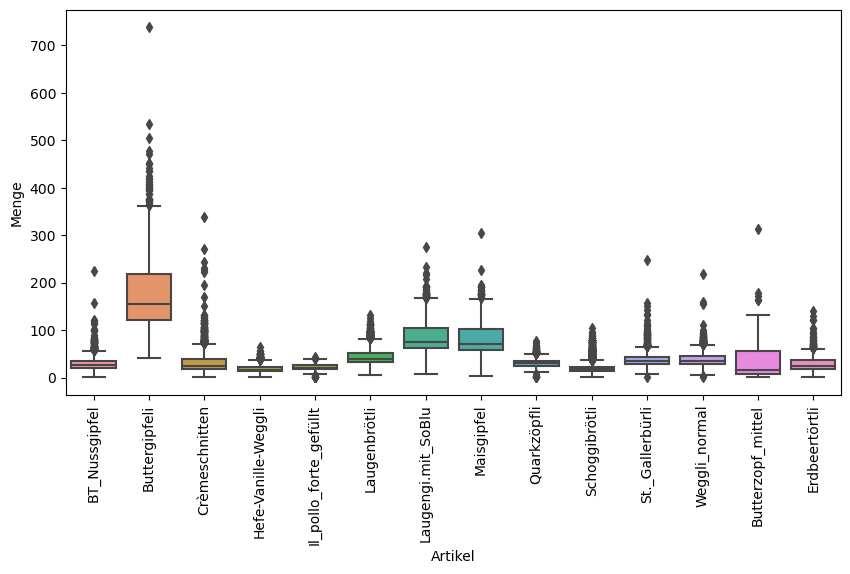

In [ ]:
# Boxplot aller Artikel
plt.figure(figsize=(10, 5))
sns.boxplot(x='Artikel', y='Menge', data=data_prep)
plt.xticks(rotation=90)
plt.show() 

In [ ]:
# Für Butterzopf_mittel: Berechnung der minimalen und maximalen Menge, sowie der Gesamtsumme der Menge
butterzopf_mittel = pre_optimized[data_prep['Artikel'] == 'Butterzopf_mittel']
print(butterzopf_mittel['Menge'].describe())
print('Summe: ', butterzopf_mittel['Menge'].sum())
print('Median: ', butterzopf_mittel['Menge'].median())


count    1975.000000
mean       31.604051
std        32.702989
min         1.000000
25%         7.000000
50%        15.000000
75%        57.000000
max       312.000000
Name: Menge, dtype: float64
Summe:  62418.0
Median:  15.0


Beim Butterzopf ist auffällig, dass bei einer relativ geringen Menge (16% von Verkaufsmenge Buttergipfel) eine hohe Variation in den gekauften Mengen besteht. Das erkennt man besonders daran, dass der Durchschnitt bei 31.6 liegt, während der Median nur bei 15 liegt.

Um dem entgegenzuwirken entfernen wir Werte größer 20, da wir davon ausgehen, dass solch große Mengen nicht ohne Voranküdigung gekauft werden. Und wenn der Kauf vorbestellt ist, dann ist er auch nicht mehr für unsere Prediciton relevant.

In [ ]:

butterzopf_mittel = butterzopf_mittel[butterzopf_mittel['Menge'] < 20]
butterzopf_test = XGB_train_and_evaluate_product_model(butterzopf_mittel, 'Butterzopf_mittel')
print(butterzopf_test)


(0.26628868852057047, 0.5942461866218105, 2.8738687501935773)


Mit sinkendem Maximalen Wert, ist die der MAPE ebenfalls. Deshalb wenden wir diese Cleaning Maßnahme nun auch im richtigen Modell an

In [ ]:
# Für Schoggibrötli: Berechnung der minimalen und maximalen Menge, sowie der Gesamtsumme der Menge
Schoggibrötli = data_prep[data_prep['Artikel'] == 'Schoggibrötli']
print(Schoggibrötli['Menge'].describe())
print('Summe: ', Schoggibrötli['Menge'].sum())
print('Median: ', Schoggibrötli['Menge'].median())

count    1906.000000
mean       22.785414
std        15.778041
min         1.000000
25%        14.000000
50%        18.000000
75%        23.000000
max       105.000000
Name: Menge, dtype: float64
Summe:  43429.0
Median:  18.0


In [ ]:
# Für Butterzopf_mittel: Berechnung der minimalen und maximalen Menge, sowie der Gesamtsumme der Menge
buttergipfeli = data_prep[data_prep['Artikel'] == 'Buttergipfeli']
print(buttergipfeli['Menge'].describe())
print('Summe: ', buttergipfeli['Menge'].sum())
print('Median: ', buttergipfeli['Menge'].median())

count    2146.000000
mean      175.318966
std        72.830889
min        42.000000
25%       121.250000
50%       155.000000
75%       218.000000
max       738.000000
Name: Menge, dtype: float64
Summe:  376234.5
Median:  155.0


Im Vergleich mit dem Buttergipfel zeigt sich, dass 

# Ablage